In [1]:
import sys
import uproot
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import csv
import io
import matplotlib.colors as colors
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
import astropy
from astropy import stats

In [92]:
npath = '/Users/Clara Escanuela/OneDrive/Escritorio/MPhys_project/root_files/'
cpath = '/Users/Clara Escanuela/Downloads/'

path = cpath

def optim_bins(mult_arry):
    
    #import astropy
    #from astropy import stats
    
    width_arry = np.array([])
    
    for arry in mult_arry: 
        #print(arry)
        width_temp = astropy.stats.freedman_bin_width(arry, return_bins=False)
        width_arry = np.append(width_arry, width_temp)
    
    energy_res = np.max(width_arry)
    print(energy_res)
    flat_arry = np.concatenate(mult_arry, axis=0)
    
    return int(round((np.max(flat_arry) - np.min(flat_arry)) / energy_res, 0))

def hist_weights(rates, data):
    weights = []
    i = 0

    for event in data:
        weight = (rates[i]*np.ones_like(event))/len(event) #fraction = expected events / num of events generated
        weights.append(weight)
        i += 1
    
    return weights

def root_input(path, filename):
    rTree = uproot.open(path + filename)
    
    rTree_event = rTree['event_tree']
    rTree_data = rTree['data_tree']
    #rTree_vuv = rTree['data_tree_vuv']
    
    #event_x_pos = np.array(rTree_event['event_x_pos'])
    event_E = np.array(rTree_event['event_E'])

    data_event = np.array(rTree_data['data_event'])
    #data_pmt = np.array(rTree_data['data_pmt'])
    data_time = np.array(rTree_data['data_time']) 

    data_index, count_scint = np.unique(data_event, return_counts=True)
    #split_pmt = np.split(data_pmt, np.cumsum(count_scint)) 
    split_time = np.split(data_time, np.cumsum(count_scint))

    return split_time, count_scint, event_E

import itertools 
#from itertools import izip

def pairwise(iterable):
    "s -> (s0,s1), (s2,s3), (s4, s5), ..."
    a = iter(iterable)
    return zip(a, a)

fname_B8 = 'events_solar_delayed.root'
fname_B82 = 'events_solar_prompt2.root'
fname_solar = 'events_b8.root'
fname_Ar36 = 'events_neutrons_36Ar_100000_foils.root'
fname_Ar40 = 'events_neutrons_40Ar_100000_foils.root'
fname_Rn = 'events_Rn222_100000_foils.root'
fname_AG = 'events_alphagamma_200000_foils.root'

B8_split_time, B8_scint, B8_event_E = root_input(path, fname_B8) 
B82_split_time, B82_scint, B82_event_E = root_input(path, fname_B82)
solar_split_time, solar_scint, solar_event_E = root_input(path, fname_solar) 

Ar36_split_time, Ar36_scint, Ar36_event_E = root_input(path, fname_Ar36)  
Ar40_split_time, Ar40_scint, Ar40_event_E = root_input(path, fname_Ar40)  
Rn_split_time, Rn_scint, Rn_event_E = root_input(path, fname_Rn)  
AG_split_time, AG_scint, AG_event_E = root_input(path, fname_AG)  

#########################

def comb(split_time, event_E):
    split_time_temp = []
    for x, y in pairwise(split_time):
        split_time_temp.append(np.append(x,y))
    
    event_E_temp = []
    for x, y in pairwise(event_E):
        event_E_temp.append(x+y)
    
    return split_time_temp, event_E_temp

B8_split_time, B8_event_E = comb(B8_split_time, B8_event_E)
AG_split_time, AG_event_E = comb(AG_split_time, AG_event_E)
outputtime = np.hstack((B8_split_time[0:4000], B82_split_time[0:6000]))

print(B8_event_E[0:10])
outputE = np.hstack((B8_event_E[0:4000], B82_event_E[0:6000]))

B8_split_time = outputtime
B8_event_E = outputE

[8.452194427931296, 10.372025903313627, 8.271617456364064, 12.591674714396076, 8.042225217157705, 10.767931515595134, 9.837133770835322, 10.87852884800631, 9.944258712391685, 14.00789293039905]


C:\Users\Clara Escanuela\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


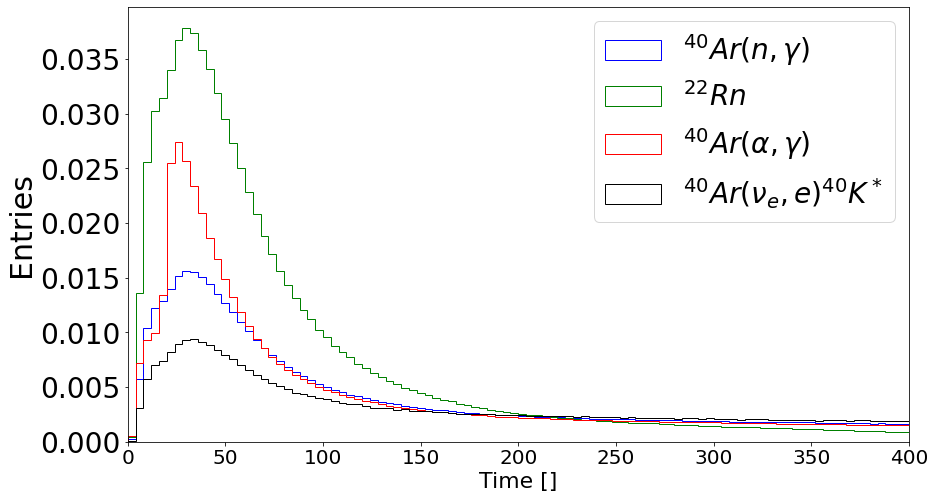

In [93]:
# Plot time distribution

data = [np.concatenate(B8_split_time)*1000, np.concatenate(AG_split_time)*1000, np.concatenate(Rn_split_time)*1000, np.concatenate(Ar40_split_time)*1000]
rates = [1, 1, 1, 1] # normalise

#num_bins = optim_bins(mult_arry)

labels = [r'$^{40}Ar(\nu_e, e)^{40}{K}^*$', r'${}^{40} Ar(\alpha, \gamma)$', r'${}^{22} Rn$', r'${}^{40} Ar(n, \gamma)$']
colors = ['black', 'red', 'green', 'blue']

plt.figure(figsize=(14,8))

n, bins, patches = plt.hist(data, stacked = False, color=colors, bins=100, range=[0, 400], label=labels, histtype='step', weights=hist_weights(rates, data))

n0 = np.max(n[0])/np.max(n[2])
n1 = np.max(n[1])/np.max(n[2])
n3 = np.max(n[3])/np.max(n[2])

plt.xlabel('Time []',fontsize=22)
plt.xticks(fontsize=20)
plt.ylabel('Entries',fontsize=30)
plt.yticks(fontsize=28)
#plt.axvline(x=0.2, linestyle = "dashed", color="black", linewidth = 0.9)
plt.xlim(-0.1, 400)

plt.legend(fontsize=28)

plt.show()

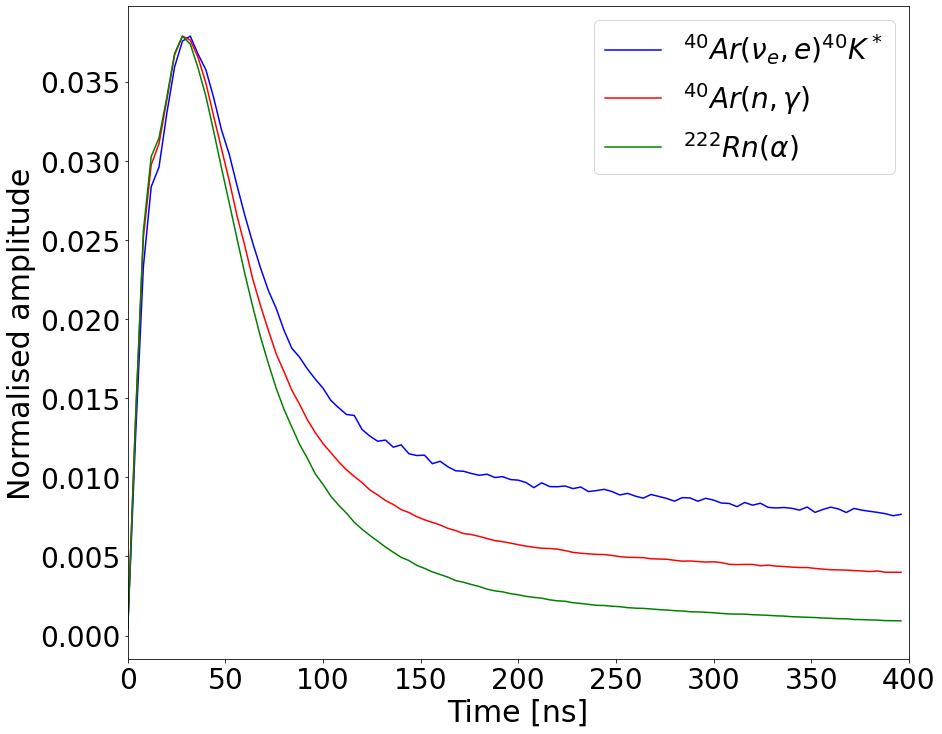

In [94]:
plt.figure(figsize=(14,12))

plt.plot(bins[0:100], n[0]/n0, label=r'$^{40}Ar(\nu_e, e)^{40}{K}^*$', color='blue')
plt.plot(bins[0:100], n[3]/n3, label=r'${}^{40} Ar(n, \gamma)$', color='red')
plt.plot(bins[0:100], n[2], label=r'${}^{222} Rn (\alpha)$', color='green')
#plt.plot(bins[0:500], n[1]/n1, label=r'${}^{40} Ar(\alpha, \gamma)$')

plt.xlabel('Time [ns]',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel('Normalised amplitude',fontsize=30)
plt.yticks(fontsize=28)
#plt.axvline(x=0.2, linestyle = "dashed", color="black", linewidth = 0.9)
#plt.axvline(x=200, color='black', linestyle='dashed', linewidth=0.7)
plt.xlim(-0.1, 400)

plt.legend(fontsize=28)

plt.show()

0.018864946547172058


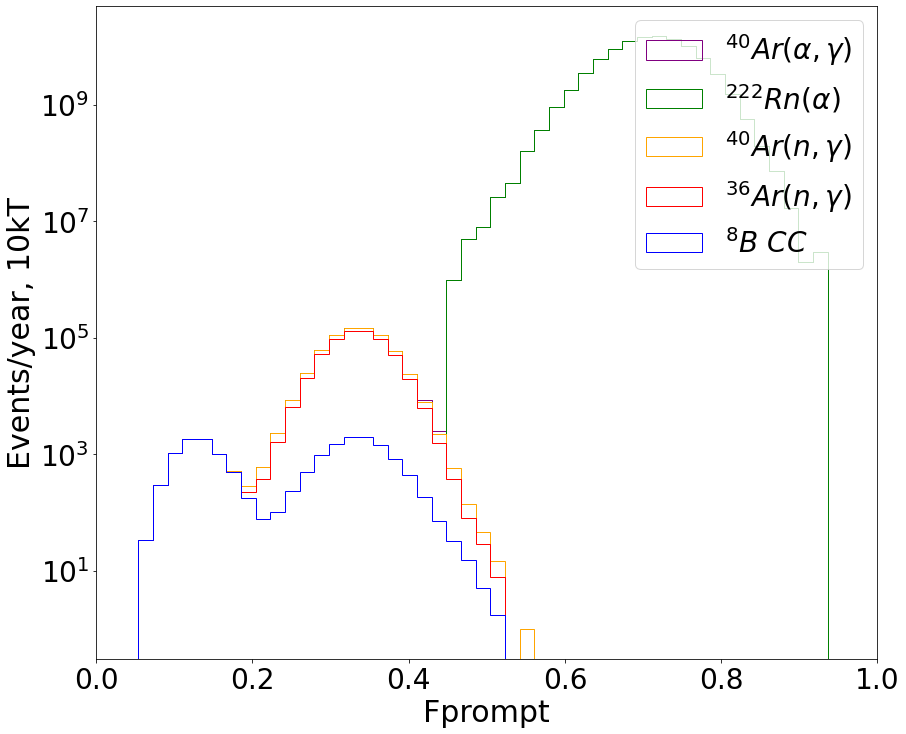

In [95]:
#Fprompt

def Fprompt(split_time, time):

    fprompt = np.array([])

    for event in split_time:
        if event.size > 0:
            fprompt = np.append(fprompt, len(event[event <= time*0.001])/len(event))
            
    return fprompt

#####################

max_time = 200

Fprompt_B8 = Fprompt(B8_split_time, max_time)

Fprompt_Ar36 = Fprompt(Ar36_split_time, max_time)
Fprompt_Ar40 = Fprompt(Ar40_split_time, max_time)
Fprompt_Rn = Fprompt(Rn_split_time, max_time)
Fprompt_AG = Fprompt(AG_split_time, max_time)


rates = [26700*0.64, 10**8*0.006, 10**8*0.994*(1/10**3), 10**(11), 3000] # normalise

data = [Fprompt_B8, Fprompt_Ar36, Fprompt_Ar40, Fprompt_Rn, Fprompt_AG]

labels = [r'${}^8 B\ CC$', r'${}^{36} Ar(n, \gamma)$', r'${}^{40} Ar(n, \gamma)$', r'${}^{222} Rn(\alpha)$', r'${}^{40} Ar(\alpha, \gamma)$']
colors = ['blue', 'red', 'orange', 'green', 'purple']

plt.figure(figsize=(14,12))

num_bins = optim_bins(data)

n_, bins_, patches_ = plt.hist(data, stacked = True, color=colors, bins=num_bins, label=labels, histtype='step', weights=hist_weights(rates, data))

plt.xlabel('Fprompt',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel('Events/year, 10kT',fontsize=30)
plt.yticks(fontsize=28)
plt.xlim([0, 1])
plt.yscale('log')

plt.legend(fontsize=28)

plt.show()

In [97]:
bin_width = bins_[1] - bins_[0]

totaln = n_[1] + n_[2] + n_[3] + n_[4]

total_sign = bin_width * sum(n_[0])
total_back = bin_width * sum(totaln)

sign = bin_width * sum(n_[0][np.where(bins_<=0.2)])
back = bin_width * sum(totaln[np.where(bins_<=0.2)])

print(sign/total_sign)
print(back)

0.3947999999999686
515.210914510204


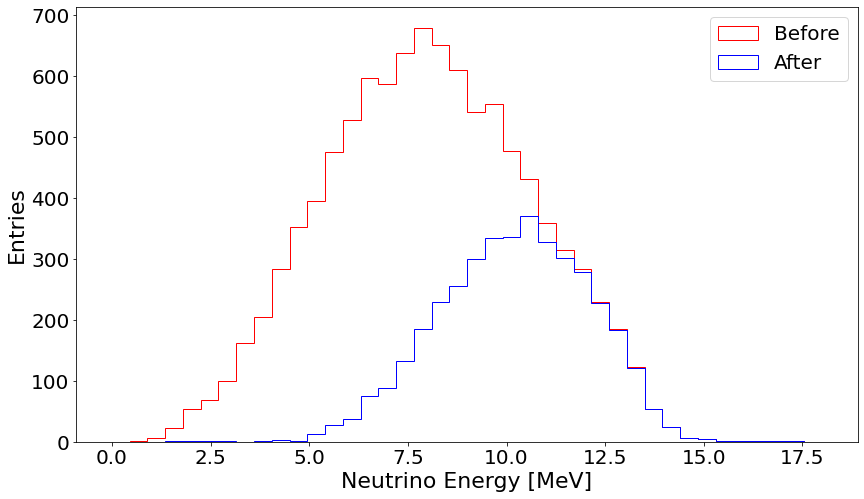

In [98]:
plt.figure(figsize=(14,8))

num_bins = 40

#Gaussian function
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-((x)-x0)**2/(2*sigma**2))


n_before1, bins_before1, patches_before1 = plt.hist(B8_event_E ,stacked = False, bins=num_bins, label='Before', range=(0,18), histtype='step', color='red')
n_after1, bins_after1, patches_after1 = plt.hist(B8_event_E[Fprompt_B8<=0.2] ,stacked = False, bins=num_bins, range=(0, 18), label='After', histtype='step', color='blue')

plt.xlabel('Neutrino Energy [MeV]',fontsize=22)
plt.xticks(fontsize=20)
plt.ylabel('Entries',fontsize=22)
plt.yticks(fontsize=20)
#plt.axvline(x=0.2, linestyle = "dashed", color="black", linewidth = 0.9)
#plt.xlim(0, 10)

plt.legend(fontsize=20)

plt.show()

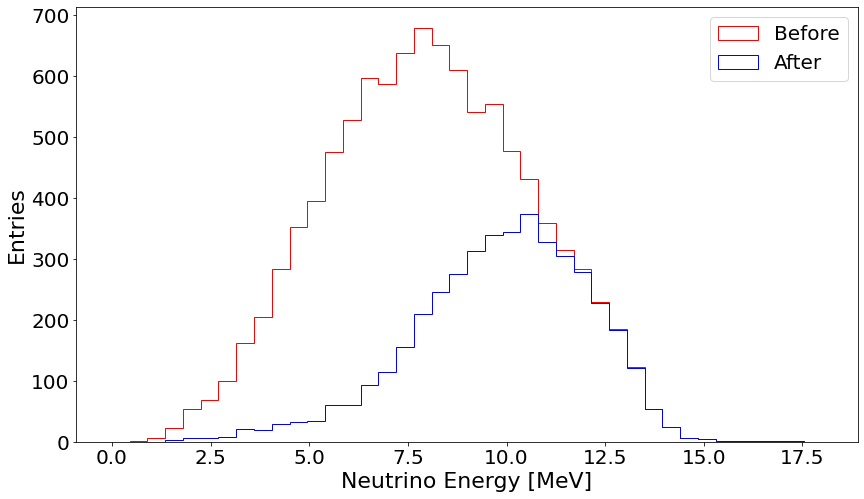

In [99]:
plt.figure(figsize=(14,8))

num_bins = 40

#Gaussian function
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-((x)-x0)**2/(2*sigma**2))


n_before, bins_before, patches_before = plt.hist(B8_event_E ,stacked = False, bins=num_bins, label='Before', range=(0,18), histtype='step', color='red')
n_after, bins_after, patches_after = plt.hist(B8_event_E[Fprompt_B8<=0.27] ,stacked = False, bins=num_bins, range=(0, 18), label='After', histtype='step', color='blue')

plt.xlabel('Neutrino Energy [MeV]',fontsize=22)
plt.xticks(fontsize=20)
plt.ylabel('Entries',fontsize=22)
plt.yticks(fontsize=20)
#plt.axvline(x=0.2, linestyle = "dashed", color="black", linewidth = 0.9)
#plt.xlim(0, 10)

plt.legend(fontsize=20)

plt.show()

C:\Users\CLARAE~1\AppData\Local\Temp/ipykernel_7944/4115954450.py:11: RuntimeWarning: invalid value encountered in double_scalars
  efficiency = n_after[i]/n_before[i]
C:\Users\CLARAE~1\AppData\Local\Temp/ipykernel_7944/4115954450.py:15: RuntimeWarning: invalid value encountered in double_scalars
  efficiency = n_after1[i]/n_before1[i]
C:\Users\CLARAE~1\AppData\Local\Temp/ipykernel_7944/4115954450.py:22: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(na*(nb-na)/nb**3)


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

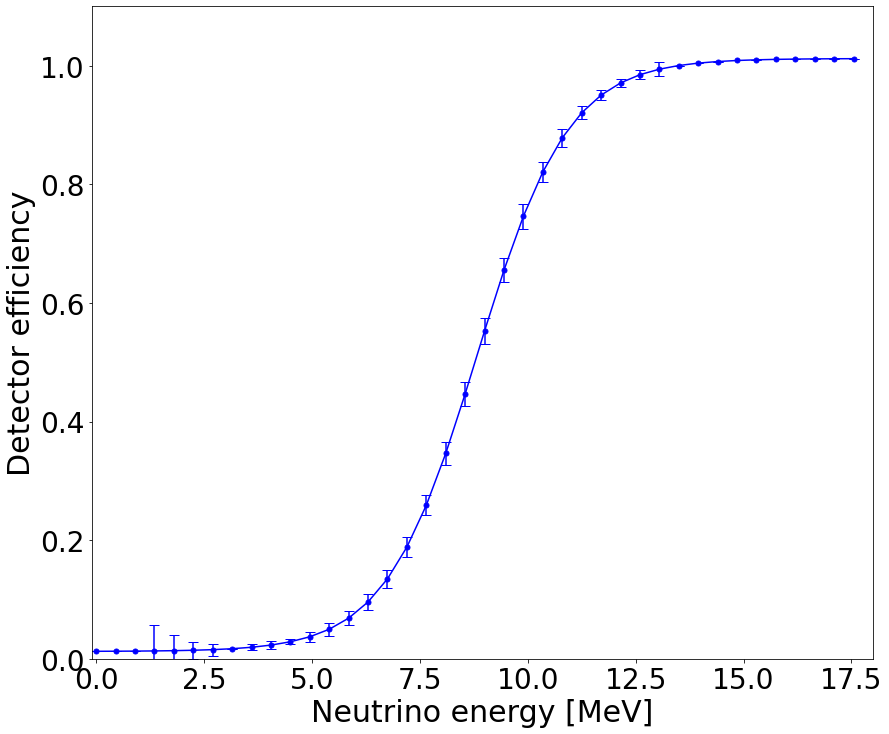

In [107]:
eff_ener = np.array([])
err_eff=np.array([])
eff_ener1 = np.array([])
err_eff1 = np.array([])
err_eff_bin = np.array([])
energy = np.linspace(0, 18, num_bins)

bin_width = bins_before[0] - bins_before[1]

for i in range(0, num_bins):
    efficiency = n_after[i]/n_before[i]
    eff_ener = np.append(eff_ener, efficiency)
    
for i in range(0, num_bins):
    efficiency = n_after1[i]/n_before1[i]
    eff_ener1 = np.append(eff_ener1, efficiency)
    
def std(na, nb):
    return (na+1)*(na+2)/((nb+2)*(nb+3))-(na+1)**2/(nb+2)**2

def errors_bin(na, nb):
    return np.sqrt(na*(nb-na)/nb**3)
    
    
for i in range(0, num_bins):
    err_eff = np.append(err_eff, std(n_after[i], n_before[i]))
    err_eff1 = np.append(err_eff1, std(n_after1[i], n_before1[i]))
    err_eff_bin =  np.append(err_eff_bin, errors_bin(n_after1[i], n_before1[i]))
    

eff_ener[np.isnan(eff_ener)] = 0 
err_eff[np.isnan(err_eff)] = 0 

eff_ener1[np.isnan(eff_ener1)] = 0 
err_eff1[np.isnan(err_eff1)] = 0 
err_eff_bin[np.isnan(err_eff_bin)] = 0 

def sigmoid(x, a, b, c, d, e):
    return a/(d + np.exp(-b*x+c))+e
    

plt.figure(figsize=(14,12))

#plt.scatter(bins_before1[0:40], eff_ener1, color='blue', marker='x', label='0.1')

popt1, pcov1 = curve_fit(sigmoid, bins_before1[0:39], eff_ener1[0:39])
popt, pcov = curve_fit(sigmoid, bins_before[0:38], eff_ener[0:38])

#plt.plot(bins_before[0:40],sigmoid(bins_before[0:40], *popt), color='blue', label='40 cm shielding')
#plt.errorbar(bins_before[0:40], sigmoid(bins_before[0:40], *popt), yerr=err_eff, fmt='o', color='blue', markersize=5, capsize=5)
plt.plot(bins_before1[0:40],sigmoid(bins_before1[0:40], *popt1), color='blue')
plt.errorbar(bins_before1[0:40], sigmoid(bins_before1[0:40], *popt1), yerr=err_eff_bin, fmt='o', color='blue', markersize=5, capsize=5)

plt.xlim(-0.1, 18)
plt.ylim(0, 1.1)

plt.ylabel('Detector efficiency', fontsize=30)
plt.xlabel(r'Neutrino energy [MeV]', fontsize=30)
#plt.yscale('log')
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
#plt.legend(fontsize=28)

No handles with labels found to put in legend.


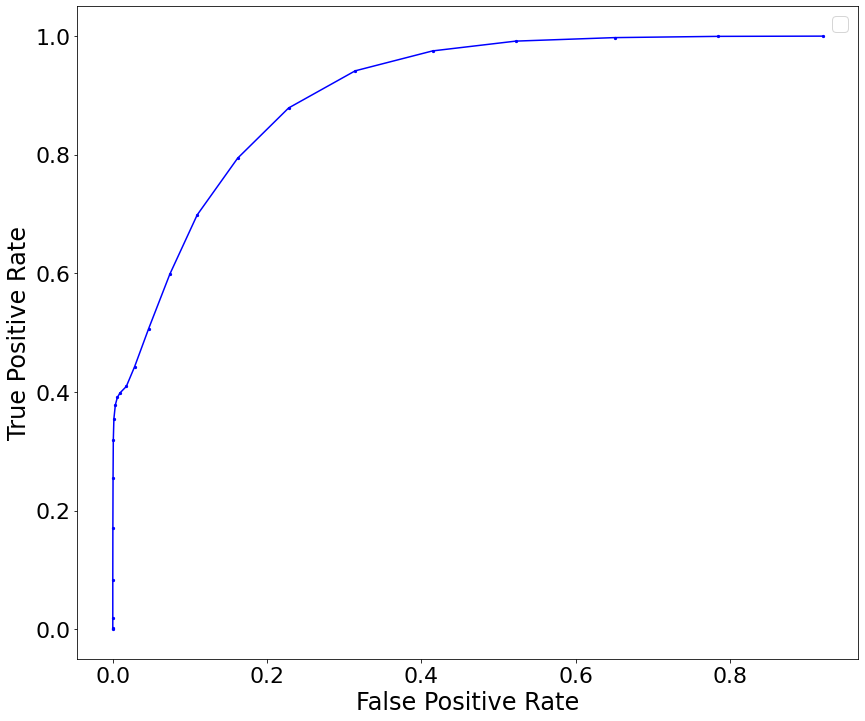

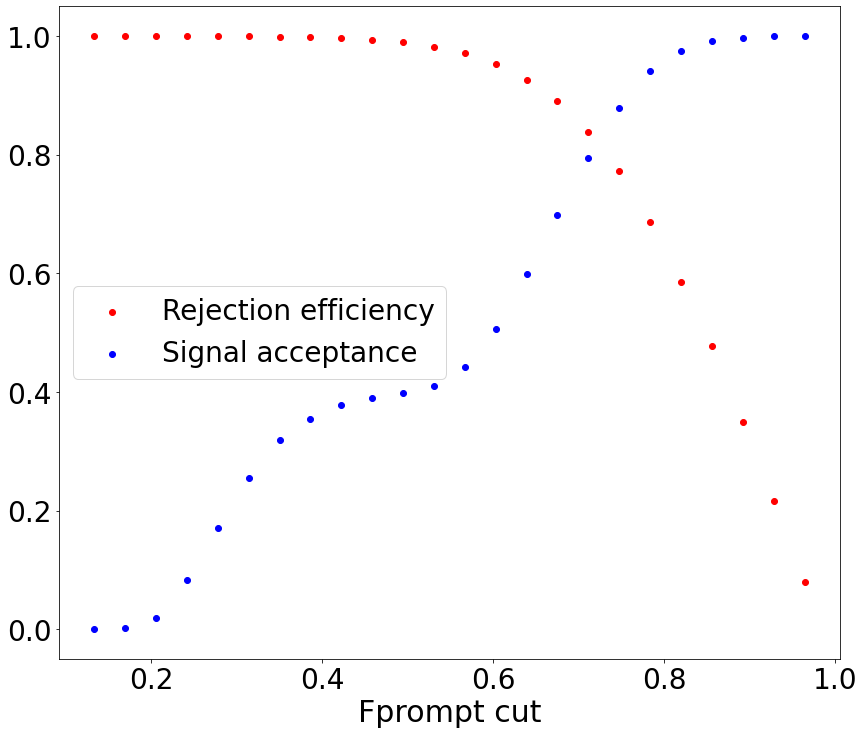

In [82]:
bin_width = bins_[1] - bins_[0]

totaln = n_[1]

total_sign = bin_width * sum(n_[0])
total_back = bin_width * sum(totaln)

false_pos = np.array([])
true_pos = np.array([])

for i in range(0, num_bins):
    sign = bin_width * sum(n_[0][0:i])
    back = bin_width * sum(totaln[0:i])
    
    efficiency = sign/total_sign
    efficiency_back = back/total_back
    false_pos = np.append(false_pos, efficiency_back)
    true_pos = np.append(true_pos, efficiency)

plt.figure(figsize=(14,12))

plt.scatter( false_pos, true_pos, s = 20, marker='.', color='blue')
plt.plot(false_pos, true_pos, color='blue')

plt.ylabel('True Positive Rate', fontsize=24)
plt.xlabel('False Positive Rate', fontsize=24)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=20)
#plt.ylim(0,1.05)
#plt.xlim(0, 1)

plt.show()

plt.figure(figsize=(14,12))

plt.scatter(bins_[0:num_bins], 1-false_pos[0:num_bins], label='Rejection efficiency', color='red')
plt.scatter(bins_[0:num_bins], true_pos[0:num_bins], label='Signal acceptance', color='blue')

plt.ylabel('', fontsize=30)
plt.xlabel('Fprompt cut', fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.legend(fontsize=28)
plt.show()

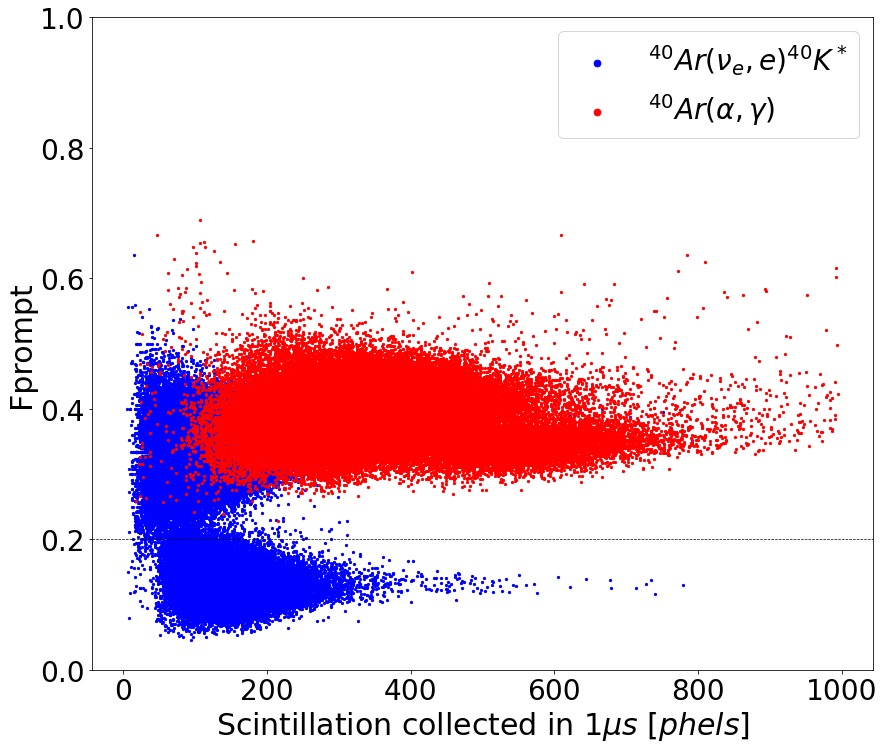

In [126]:
#########################

def scint_timewindow(split_time, set_time):
    #time is in microseconds
    i = 0
    scint_output = np.array([])

    for time in split_time:
        mask = (time <= set_time)
    
        if time.size > 0:
            scint_output = np.append(scint_output, len(time[mask])) # number of photons detected in time window
        i += 1
    
    return scint_output


t_window = 1

signl_wind = scint_timewindow(B8_split_time, t_window)
bkg_wind = scint_timewindow(AG_split_time, t_window)

#########################

plt.figure(figsize=(14,12))

sig_label = r'$^{40}Ar(\nu_e, e)^{40}{K}^*$'
bkg_label = r'${}^{40} Ar(\alpha, \gamma)$'

num_mask = 2000
scint_mask = 1000
plt.scatter(signl_wind[signl_wind < scint_mask], Fprompt_B8[signl_wind < scint_mask], s = 20, label=sig_label, marker='.', color='blue')

plt.scatter(bkg_wind[bkg_wind < scint_mask], Fprompt_AG[bkg_wind < scint_mask], s = 20, label=bkg_label, marker='.', color='red')
plt.axhline(y=0.2, color='black', linestyle='dashed', linewidth=0.7)

plt.ylabel('Fprompt', fontsize=30)
plt.xlabel(r'Scintillation collected in $1 \mu s$ [$phels$]', fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.legend(markerscale=3, fontsize=28)
plt.ylim(0,1)

plt.show()
